### Animal Detection 

- <b>vgg16</b> : Visual Geometry Group and 16 refers to the number of weight layers in the network, including convolutional and fully connected layers (not counting the pooling layers)

#### Model Architecture
- <b>Convolutional Layers</b>: The network consists of 13 convolutional layers. 
- <b>Max-Pooling Layers</b>: There are 5 max-pooling layers that follow the convolutional layers.
- <b>Fully Connected Layers</b>: After the convolutional and pooling layers, the model has three fully connected layers.

### importing

In [ ]:
!pip3 install keras


In [2]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from tensorflow.keras.utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Loading up our image datasets

In [3]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [4]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

### Creation of weights/features with VGG16  ( dont run)

In [ ]:
# don't run this

# bottle neck features are attained from an intermediate layer in the model to save training time.

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  #Calculates the number of prediction steps per epoch
   
bottleneck_features_train = vgg16.predict(generator, predict_size_train)  #Uses the VGG16 model to predict and extract features from the training images. These features are called "bottleneck features" 
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)  #Saves the generated bottleneck features as Numpy's save function.
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 15897 images belonging to 7 classes.


2024-07-23 14:02:56.462291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 844s 3s/step
Time:  0:14:11.089157


In [ ]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


## Characteristics of Bottleneck Features:

- Intermediate Representations: They represent the data at a certain level of abstraction after it has passed through several layers of the neural network.

- High-Level Features: These features capture high-level patterns such as shapes, textures, and other complex structures in the input data.

- Fixed-Length Vectors: Regardless of the input image size, bottleneck features are typically fixed-length vectors, making them easier to work with for further processing.
Reduced Dimensionality:

- They often have reduced dimensionality compared to the original input data, which helps in reducing computational load and memory requirements.

In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

# Uses a pre-trained VGG16 model to extract and save intermediate features (bottleneck features) to a file.

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2826 images belonging to 7 classes.
57/57 [==============================] - 160s 3s/step
Time:  0:02:41.724373


In [ ]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [5]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3496 images belonging to 7 classes.
15/70 [=====>........................] - ETA: 11:20

KeyboardInterrupt: 

### Loading training, validation and testing data

In [12]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  # Are one-hot encoded labels
         shuffle=False)  # same order
   
nb_train_samples = len(generator_top.filenames)  # size of them
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 15897 images belonging to 7 classes.


In [13]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2826 images belonging to 7 classes.


In [14]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 3496 images belonging to 7 classes.


### Training our model VGG16

In [8]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/7
318/318 [==============================] - 7s 20ms/step - loss: 1.4322 - acc: 0.6809 - val_loss: 0.4257 - val_acc: 0.8641
Epoch 2/7
318/318 [==============================] - 8s 27ms/step - loss: 0.6556 - acc: 0.8230 - val_loss: 0.4097 - val_acc: 0.8762
Epoch 3/7
318/318 [==============================] - 7s 21ms/step - loss: 0.4807 - acc: 0.8632 - val_loss: 0.3184 - val_acc: 0.9016
Epoch 4/7
318/318 [==============================] - 7s 22ms/step - loss: 0.3824 - acc: 0.8904 - val_loss: 0.3092 - val_acc: 0.9048
Epoch 5/7
318/318 [==============================] - 7s 23ms/step - loss: 0.3163 - acc: 0.9059 - val_loss: 0.3514 - val_acc: 0.8917
Epoch 6/7
318/318 [==============================] - 7s 21ms/step - loss: 0.2584 - acc: 0.9190 - val_loss: 0.2990 - val_acc: 0.9165
Epoch 7/7
57/57 [==============================] - 0s 7ms/step - loss: 0.3109 - acc: 0.9144
[INFO] accuracy: 91.44%
[INFO] Loss: 0.3108706772327423
Time:  0:00:53.255201


In [9]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 2514307 (9.59 MB)
Trainable params: 251430

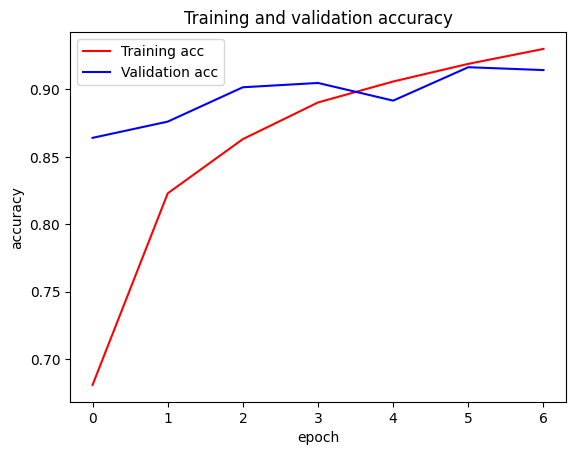

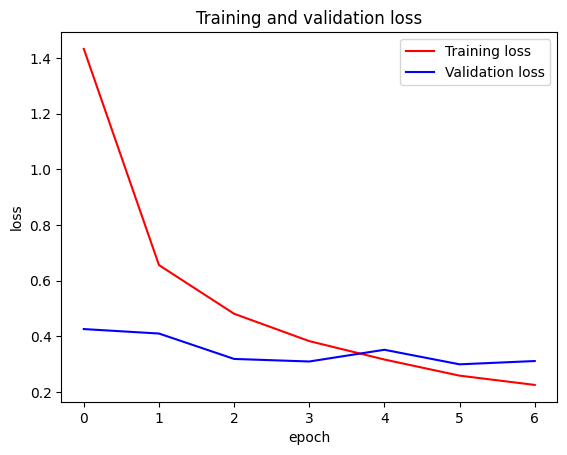

In [15]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [16]:
model.evaluate(test_data, test_labels)

110/110 [==============================] - 0s 3ms/step - loss: 0.2632 - acc: 0.9236


[0.2632015347480774, 0.9236270189285278]

## Classification metrics and Confusion Matrix

### Classification Metrics

In [17]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[1.62910298e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.54943490e-01 0.00000000e+00]
   [9.73948613e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.17594361e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.81749892e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.90739673e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.19956088e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.68091452e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.71549773e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.10543633e-01 ... 0.00000000e+00
    3.51710737e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.56101048e-01 ... 0.00000000e+00
    1.31017268e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 4.20266658e-0

In [11]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells', 'tiger']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

 butterflies       0.92      0.96      0.94       371
    chickens       0.79      0.91      0.85       203
   elephants       0.89      0.78      0.83       152
      horses       0.97      0.92      0.94       472
     spiders       0.95      0.89      0.92       403
   squirells       0.84      0.91      0.88       244
       tiger       1.00      0.97      0.99      1651

   micro avg       0.95      0.94      0.94      3496
   macro avg       0.91      0.91      0.91      3496
weighted avg       0.95      0.94      0.95      3496
 samples avg       0.94      0.94      0.94      3496



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

In [12]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [13]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [14]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


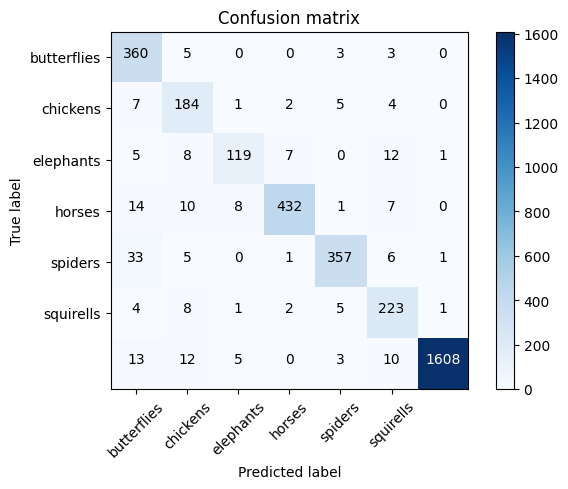

In [15]:
plot_confusion_matrix(confusion_matrix, ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'])

Normalized confusion matrix


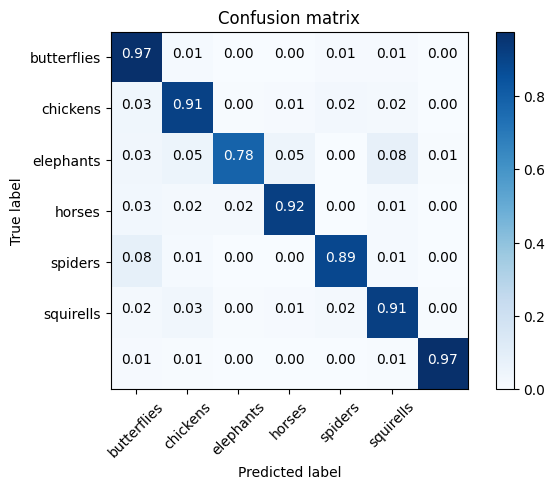

In [16]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'],
                     normalize=True)

## Testing images on model

In [17]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [18]:
from PIL import Image

def test_single_image(path):
    animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}

    # Assuming class_predicted[0] is an array of probabilities
    if isinstance(class_predicted[0], np.ndarray):
        # Find the index of the highest probability
        predicted_class_id = np.argmax(class_predicted[0])
    else:
        # Handle the case where class_predicted[0] is not an array
        raise ValueError("class_predicted[0] should be a numpy array of probabilities.")

    # Map the predicted class
    predicted_class_label = inv_map.get(predicted_class_id, "Unknown Class")

    image = Image.open(path)

    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')  # Hide axis labels
    plt.show()


[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 22ms/step
ID: 0, Label: butterflies 0.0%
ID: 1, Label: chickens 0.39%
ID: 2, Label: elephants 0.03%
ID: 3, Label: horses 0.9%
ID: 4, Label: spiders 0.0%
ID: 5, Label: squirells 98.67%
Final Decision:
.
..
...
1/1 [==============================] - 0s 18ms/step


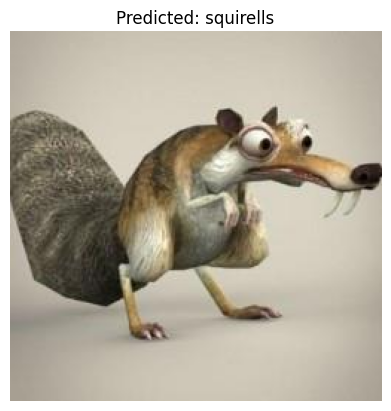

In [20]:
path = '/Users/anand/Desktop/ai/animal-image-classifications/data/test/scrat.jpg'
test_single_image(path)